# Задача
В этой работе вам предлагается решить задачу регрессии, а именно построить алгоритм, определяющий качество вина на основе физико-химических тестов:
 - fixed acidity
 - volatile acidity
 - citric acid
 - residual sugar
 - chlorides
 - free sulfur dioxide
 - total sulfur dioxide
 - density
 - pH
 - sulphates
 - alcohol 
 
Более подробно про признаки можно почитать [здесь](https://archive.ics.uci.edu/ml/datasets/wine+quality). Целевой признак записан в переменной *quality*.

В этой задаче для обучения будут использовать 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

# Решение

Загрузите набор данных *winequality-red.csv* с помощью `pandas` (скачать можно [здесь](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [3]:
# База
RANDOM_STATE = 43
import pandas as pd
import numpy as np
import sklearn as skl

# Препроцессинг данных
from sklearn.preprocessing import StandardScaler # Препроцессинг данных

# Трансформация данных
from sklearn.decomposition import PCA

# Вспомогательные классы/функции
from sklearn.model_selection import GridSearchCV # для поиска оптимальных гиперпараметров
from sklearn.model_selection import StratifiedKFold # для лучшего контроля кросс-валидации
from sklearn.metrics import classification_report # для быстрого просмотра оценок моделей
from sklearn.metrics import accuracy_score,confusion_matrix # для функции plot_confusionmatrix
from sklearn.base import clone # for model cloning
from sklearn import tree # для демонстрации: как устроено дерево

# Ключевые модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns # for data representation (kinda)
import scikitplot as skplt
from scikitplot.metrics import plot_roc # for roc curve

## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения. Удалите из выборки все объекты с пропусками и дубликаты.
2. Выделите 70% выборки для обучения и дальнейшего анализа.
3. Проанализируйте признаки и по необходимости предобработайте их. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную (НЕ забудьте удалить ее из датасета, когда будете обучать модель).

In [4]:
dataset_pd = pd.read_csv('winequality-red.csv', delimiter=';')
dataset_pd.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


In [5]:
dataset_pd.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [6]:
dataset_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Проверим есть ли пропуски данных:

In [7]:
dataset_pd.isnull().sum().sum()

0

Проверим есть ли дубликаты данных:

In [8]:
dataset_drop_dup = dataset_pd.drop_duplicates(inplace=False)
print("Dataset shape before .drop_duplicates method:", dataset_pd.shape)
print("Dataset shape after .drop_duplicates method:", dataset_drop_dup.shape)

Dataset shape before .drop_duplicates method: (1599, 12)
Dataset shape after .drop_duplicates method: (1359, 12)


In [9]:
# Обнаружены дубликаты данных, поэтому далее работаем с уникальным датасетом:
dataset_pd.drop_duplicates(inplace=True)
print("Dataset shape after .drop_duplicates method:", dataset_pd.shape)

Dataset shape after .drop_duplicates method: (1359, 12)


Посмотрим распределение фичей оносительно друг друга: может некоторые из них окажутся скореллированными. Для начала построим попарное распределение фичей.

In [10]:
sns.pairplot(dataset_pd.drop(columns=['quality'], inplace=False), kind='scatter', diag_kind='kde')

Видно, что некоторые пары явно скореллированы, как например `fixed acidity` и `density`. И хотя сама по себе корелляция данных не дает точного ответа плохой/хороший датасет, высокая корелляция означает линейно зависимые столбцы в датасете, а это уже серьезно. Для количественного ответа на этот вопрос, построим матрицу корелляций и исходя из нее будем делать выводы какие фичи мы отбросим.

Матрица корреляций встроена в классе `pd.DataFrame`, вычисляем __[методом Пирсона](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)__:

In [11]:
def plot_corr_matrix_diag(corr):
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    plot = (corr
     .style
     .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
     .highlight_null(color='#f1f1f1')  # Color NaNs grey
     .format(precision=2))
    
    return plot

In [12]:
corr = dataset_pd.drop(columns=['quality'], inplace=False).corr()
plot_corr_matrix_diag(corr)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
volatile acidity,-0.26,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
citric acid,0.67,-0.55,nan,nan,nan,nan,nan,nan,nan,nan,nan
residual sugar,0.11,-0.00,0.14,nan,nan,nan,nan,nan,nan,nan,nan
chlorides,0.09,0.06,0.21,0.03,nan,nan,nan,nan,nan,nan,nan
free sulfur dioxide,-0.14,-0.02,-0.05,0.16,0.00,nan,nan,nan,nan,nan,nan
total sulfur dioxide,-0.10,0.07,0.05,0.20,0.05,0.67,nan,nan,nan,nan,nan
density,0.67,0.02,0.36,0.32,0.19,-0.02,0.08,nan,nan,nan,nan
pH,-0.69,0.25,-0.55,-0.08,-0.27,0.06,-0.08,-0.36,nan,nan,nan
sulphates,0.19,-0.26,0.33,-0.01,0.39,0.05,0.04,0.15,-0.21,nan,nan


In [13]:
plot_corr_matrix_diag(corr.mask(abs(corr)<=0.6))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
fixed acidity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
volatile acidity,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
citric acid,0.67,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
residual sugar,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
chlorides,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
free sulfur dioxide,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
total sulfur dioxide,nan,nan,nan,nan,nan,0.67,nan,nan,nan,nan,nan
density,0.67,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pH,-0.69,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
sulphates,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


Согласно матрице корреляций можно составить список пар признаков с корреляцией больше, чем $0.6$:
- [`fixed acidity`, `citric acid`]
- [`fixed acidity`, `density`]
- [`fixed acidity`, `pH`]
- [`free sulfur dioxide`, `total sulfur dioxide`]

Что с этим делать? Согласно, например, __[этим данным](https://www.extension.iastate.edu/wine/total-sulfur-dioxide-why-it-matters-too/)__, пару [`free sulfur dioxide`, `total sulfur dioxide`] не стоит удалять из анализа. Также признак `fixed acidity` больше всего коррелирует с другими признаками и его следовало бы удалить. Но т.к. далее мы будем проводить PCA, на этом этапе ничего удалять не будем.

In [14]:
#dataset_pd.drop(columns=['fixed acidity'], inplace=True)
#dataset_pd


Оставим так. По условию задания нам не требуется удалять корреляции и выбросы данных, но __[согласно датасету](https://archive.ics.uci.edu/dataset/186/wine+quality)__ рекомендуется проводить более подробный анализ.

Обработка выбросов:

c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\ProgramData\anaconda3\envs\PythonDL\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

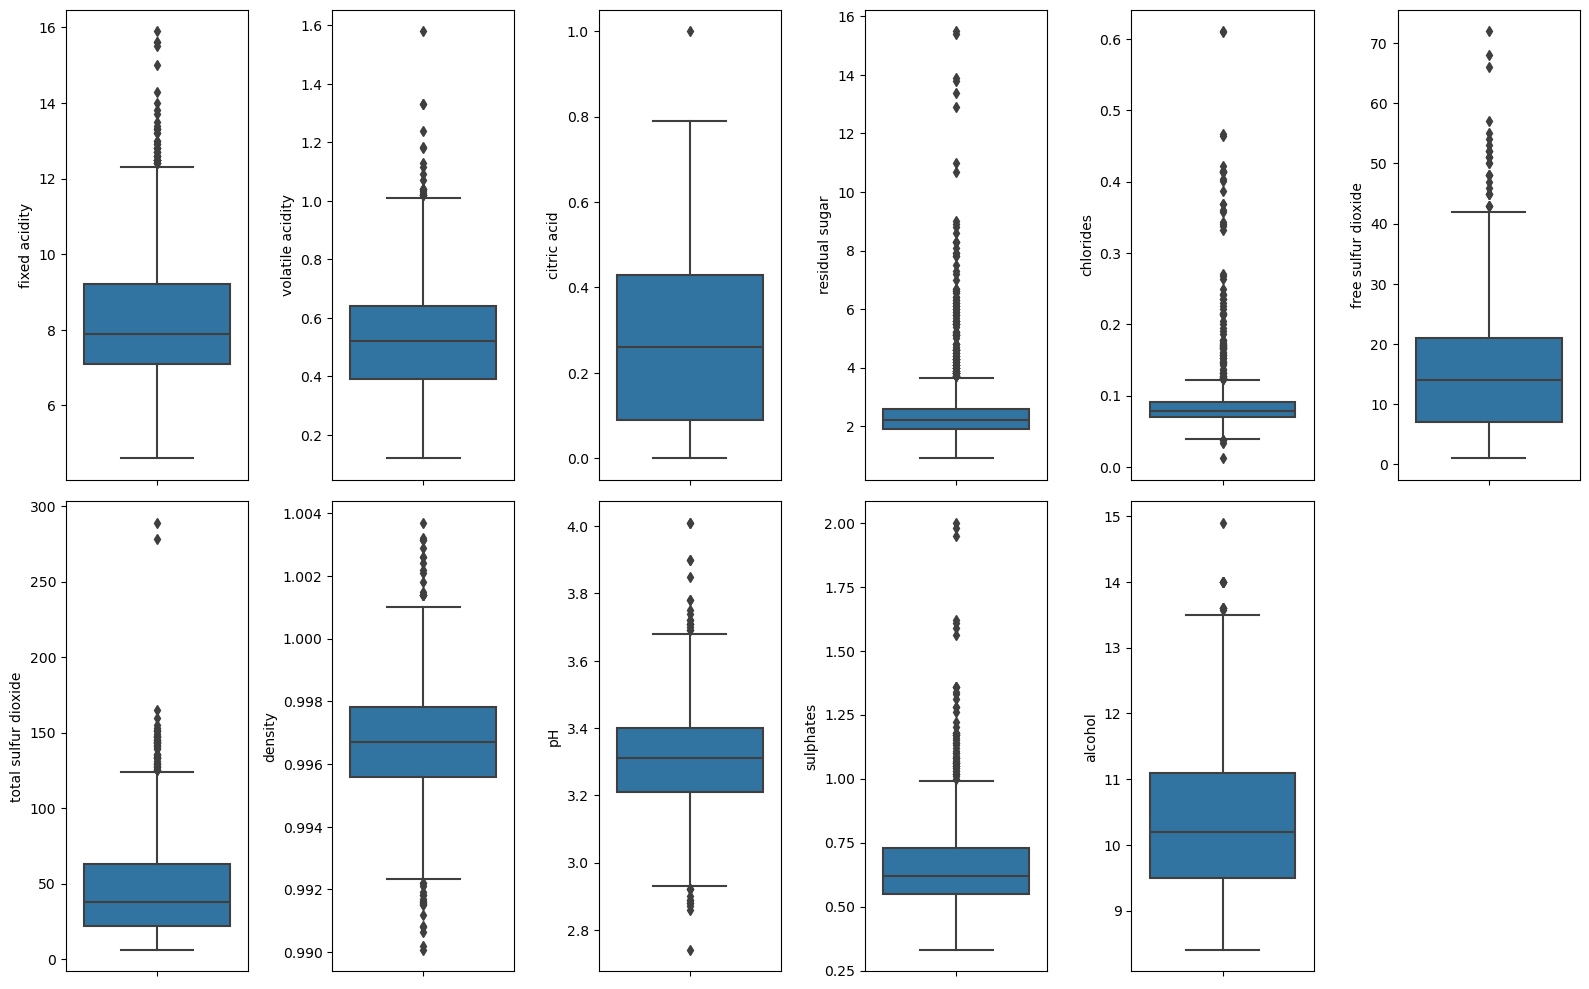

In [15]:
plt.figure(figsize=(16,10))

for i,col in enumerate(dataset_pd.drop(columns=['quality'], inplace=False).columns.tolist()):    
    plt.subplot(2,6,i + 1)
    sns.boxplot(y=col, data=dataset_pd.drop(columns=['quality'], inplace=False))

plt.tight_layout()

plt.show()

Согласно этим "ящикам с усами" и `sns.pairplot` можно сделать некоторые выводы по аномальным данных, т.е. по исключительным винам. Выбросы представлены черным ромбом на графиках выше - это статистически верные выбросы, но они могут нести определенную ценность в нахождении закономерностей среди образцов. Мы не будем удалять все выбросы, а удалим самые экстремальные:

In [16]:
test = dataset_pd.copy()
test.shape

(1359, 12)

In [17]:
test.drop(test[test["total sulfur dioxide"] >= 250].index, inplace=True)

In [18]:
test.drop(test[test["volatile acidity"] >= 1.4].index, inplace=True)

In [19]:
test.drop(test[test["citric acid"] == 1.0].index, inplace=True)

In [20]:
test.drop(test[test["chlorides"] >= 0.5].index, inplace=True)

In [21]:
test.drop(test[test["free sulfur dioxide"] >= 60].index, inplace=True)

In [22]:
test.drop(test[test["sulphates"] >= 1.5].index, inplace=True)

In [23]:
test.drop(test[test["alcohol"] >= 14.5].index, inplace=True)

Обновим исходный датасет:

In [24]:
dataset_pd = test.copy()
dataset_pd

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


___

Начнем трансформацию данных:

In [25]:
dataset_np = dataset_pd.to_numpy()
data = dataset_np[:, :-1].astype(float)
target = dataset_np[:, -1]

print(data.shape, target.shape)

(1344, 11) (1344,)


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.30, random_state=777)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(940, 11) (940,) (404, 11) (404,)


Т.к. у нас остались аномальные данные, стоит использовать `RobustScaler` вместо `StandartScaler` - таким образом мы учтем эти выбросы в стандартизации данных.

In [27]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(X_train)
#scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучение модели регрессии

Постройте модель регрессии, используя 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

Для начала используйте гиперпараметры по умолчанию.

Рассчитайте среднее качество кросс-валидации модели как долю дисперсии зависимой переменной (коэффициент детерминации) $R^2$. Каким получилось качество? Какой алгоритм вы бы выбрали для дальнейшей работы? Обоснуйте свой выбор.

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

dt_basic = DecisionTreeRegressor(random_state=RANDOM_STATE)
ab_basic = AdaBoostRegressor(random_state=RANDOM_STATE)
rf_basic = RandomForestRegressor(random_state=RANDOM_STATE) # ради интереса: будем также использовать 'max_features': None, который эмпирически больше подходит под задачу регрессии. Результаты в сравнении без/с PCA трансформацией.

In [81]:
custom_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print("r2 scoring")

for estimator in {dt_basic, ab_basic, rf_basic}:
    res = cross_val_score(estimator, X_train_scaled, y_train, scoring='r2', cv=custom_cv)
    mean = sum(res)/len(res)
    print(str(estimator.__class__.__name__), ": ", mean, sep='')

r2 scoring
DecisionTreeRegressor: -0.2784466705251428
RandomForestRegressor: 0.37480249913632796
AdaBoostRegressor: 0.3411850148514009


Точность решающего дерева получилась отрицательной, а это значит, что модель предсказывает ответы хуже, чем модель, возвращающая среднее значение целевой переменной. Можно попробовать сделать прунинг в надежде улучшить точность.

Бессмысленно делать его для каждой итерации кросс-валидации - мы не сможем сравнить эти деревья, т.к. гиперпараметр `ccp_alpha` будет подбираться под каждую итерацию. Поэтому прунинг будет на всей тренировочной выборке:

In [30]:
# Сделаем анализ исходного дерева с отрицательным r2-score
dt_basic.fit(X_train_scaled, y_train)
path = dt_basic.cost_complexity_pruning_path(X_train_scaled, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [31]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = clone(dt_basic)
    clf.set_params(ccp_alpha=ccp_alpha, max_depth=None, random_state=RANDOM_STATE)
    clf.fit(X_train_scaled, y_train)
    clfs.append(clf)

In [32]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

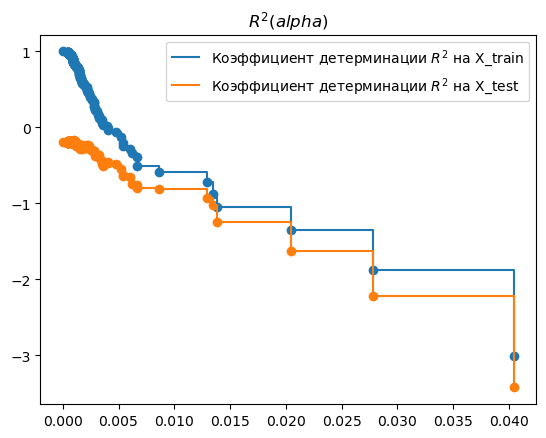

In [33]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train_scaled)
    y_test_pred = c.predict(X_test_scaled)
    train_acc.append(r2_score(c.predict(X_train_scaled),y_train))
    test_acc.append(r2_score(c.predict(X_test_scaled),y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='Коэффициент детерминации $R^2$ на X_train',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='Коэффициент детерминации $R^2$ на X_test',drawstyle="steps-post")
plt.legend()
plt.title('$R^2(alpha)$')
plt.show()

Согласно графику, стоит выбрать `ccp_alpha` $\in [0.006; 0.010]$, чтобы не потерять в возможности точно предсказывать ответы. Пусть `ccp_alpha` $=0.008$

In [34]:
ccp_alpha_hand_picked = 0.008
dt_basic_pruned=clone(dt_basic)
dt_basic_pruned.set_params(ccp_alpha=ccp_alpha_hand_picked, max_depth=None, random_state=42)

dt_basic_pruned.fit(X_train_scaled, y_train)
print("r2_score:", r2_score(y_test, dt_basic_pruned.predict(X_test_scaled)))

r2_score: 0.25496686037029626


Итого у дерева с прунингом на всей тренировочной выборке скор значительно повысился! Теперь построим модель с найденным значением `ccp_alpha` и проведем ее кросс-валидацию:

In [82]:
res_noGridSearch_noPCA = {}
for estimator in {dt_basic, dt_basic_pruned, ab_basic, rf_basic}:
    res = cross_val_score(estimator, X_train_scaled, y_train, scoring='r2', cv=custom_cv)
    mean = round(sum(res)/len(res), 4)

    # форматирование вывода
    if (estimator.__class__.__name__ == "DecisionTreeRegressor"):
        #print(estimator.get_params())
        dt_dict = estimator.get_params()
        if (dt_dict['ccp_alpha'] != 0.0):
            print("Pruned "+str(estimator.__class__.__name__)+" with ccp_alpha="+str(dt_dict['ccp_alpha']), ": ", mean, sep='')
            res_noGridSearch_noPCA['pruned'] = mean
        else:
            print("Non-pruned "+str(estimator.__class__.__name__), ": ", mean, sep='')
            res_noGridSearch_noPCA['non_pruned'] = mean
    else:
        print(str(estimator.__class__.__name__), ": ", mean, sep='')
        res_noGridSearch_noPCA[str(estimator.__class__.__name__)] = mean

Non-pruned DecisionTreeRegressor: -0.2784
RandomForestRegressor: 0.3748
AdaBoostRegressor: 0.3412
Pruned DecisionTreeRegressor with ccp_alpha=0.008: 0.293


По итогу получается печальная картина, когда у одних из самых сильных моделей Коэффициент детерминации $R^2$ составляет $0.35-0.4$ . После прунинга дерева скор относительно обычного дерева сильно улучшился - $0.29$. Далее будем работать с `AdaBoostRegressor`.

___

Теперь сделаем подбор оптимальных гиперпараметров. Сделайте поиск по сетке с помощью кросс-валидации. Изменилось ли качество алгоритмов? Почему?

In [36]:
dt_better = DecisionTreeRegressor(random_state=RANDOM_STATE)
ab_better = AdaBoostRegressor(random_state=RANDOM_STATE)
rf_better = RandomForestRegressor(random_state=RANDOM_STATE)

In [37]:
res_withGridSearch_noPCA = {}
def print_params(res):
    for key in res:
        value = res[key]
        if key == "ccp_alpha":
            print('\t', str(key)+" =", value)
        if key == "criterion":
            print('\t', str(key)+" =", value)
        if key == "max_depth":
            print('\t', str(key)+" =", value)
        if key == "max_features":
            print('\t', str(key)+" =", value)
        if key == "learning_rate":
            print('\t', str(key)+" =", value)
        if key == "loss":
            print('\t', str(key)+" =", value)
        if key == "n_estimators":
            print('\t', str(key)+" =", value)

## **Решающее дерево**

Попробуем внедрить в поиск по сетке прунинг дерева - поиск оптимального `ccp_alpha`:

In [38]:
param_grid = {'max_features': ['sqrt', 'log2'],
              'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion' :['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
              'ccp_alpha' : [0.000, 0.002, 0.004, 0.006, 0.008, 0.010],
             }

grid_search_dt = GridSearchCV(estimator=dt_better, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_dt.fit(X_train_scaled, y_train)

dt_better = grid_search_dt.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(dt_better.get_params())

res_withGridSearch_noPCA['pruned'] = grid_search_dt.best_score_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
best estimator hyperparameters:
	 ccp_alpha = 0.008
	 criterion = squared_error
	 max_depth = 8
	 max_features = sqrt


In [39]:
print("Decision Tree with general hyperparameters: r2 score =", res_noGridSearch_noPCA['pruned'])
print("Decision Tree with oprimal hyperparameters: r2 score =", res_withGridSearch_noPCA['pruned'])

Decision Tree with general hyperparameters: r2 score = 0.293
Decision Tree with oprimal hyperparameters: r2 score = 0.30723240430109383


Здесь и далее мы увидим незначительные увеличения точности модели при подборе оптимальных гиперпараметров. Это можно обосновать тем, что большинство гиперпараметров выставляются автоматически, согласно документации SKLearn.

## **AdaBoost**

In [40]:
param_grid = {'loss': ['linear', 'square', 'exponential'],
              'n_estimators': [10, 50, 100, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
             }

grid_search_ab = GridSearchCV(estimator=ab_better, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_ab.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=True),
             estimator=AdaBoostRegressor(random_state=43),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='r2', verbose=1)

In [41]:
ab_better = grid_search_ab.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(ab_better.get_params())

res_withGridSearch_noPCA[str(ab_better.__class__.__name__)] = grid_search_ab.best_score_

best estimator hyperparameters:
	 learning_rate = 0.1
	 loss = square
	 n_estimators = 50


In [42]:
name = str(ab_better.__class__.__name__)
print("AdaBoost Regressor with general hyperparameters: r2 score =", res_noGridSearch_noPCA[name])
print("AdaBoost Regressor with oprimal hyperparameters: r2 score =", res_withGridSearch_noPCA[name])

AdaBoost Regressor with general hyperparameters: r2 score = 0.3412
AdaBoost Regressor with oprimal hyperparameters: r2 score = 0.36396379977461985


## **Случайный лес**

In [83]:
param_grid = {'max_features': ['sqrt', 'log2', None],
              'n_estimators': [10, 50, 100, 500],
              'criterion' :['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
             }

grid_search_rf = GridSearchCV(estimator=rf_better, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=True),
             estimator=RandomForestRegressor(criterion='poisson',
                                             max_features='sqrt',
                                             random_state=43),
             param_grid={'criterion': ['poisson', 'squared_error',
                                       'absolute_error', 'friedman_mse'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='r2', verbose=1)

In [84]:
rf_better = grid_search_rf.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(rf_better.get_params())

res_withGridSearch_noPCA[str(rf_better.__class__.__name__)] = grid_search_rf.best_score_

best estimator hyperparameters:
	 ccp_alpha = 0.0
	 criterion = poisson
	 max_depth = None
	 max_features = sqrt
	 n_estimators = 100


In [86]:
name = str(rf_better.__class__.__name__)
print("Random Forest Regressor with general hyperparameters: r2 score =", res_noGridSearch_noPCA[name])
print("Random Forest Regressor with oprimal hyperparameters: r2 score =", res_withGridSearch_noPCA[name])

Random Forest Regressor with general hyperparameters: r2 score = 0.3748
Random Forest Regressor with oprimal hyperparameters: r2 score = 0.39086615220919274


Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

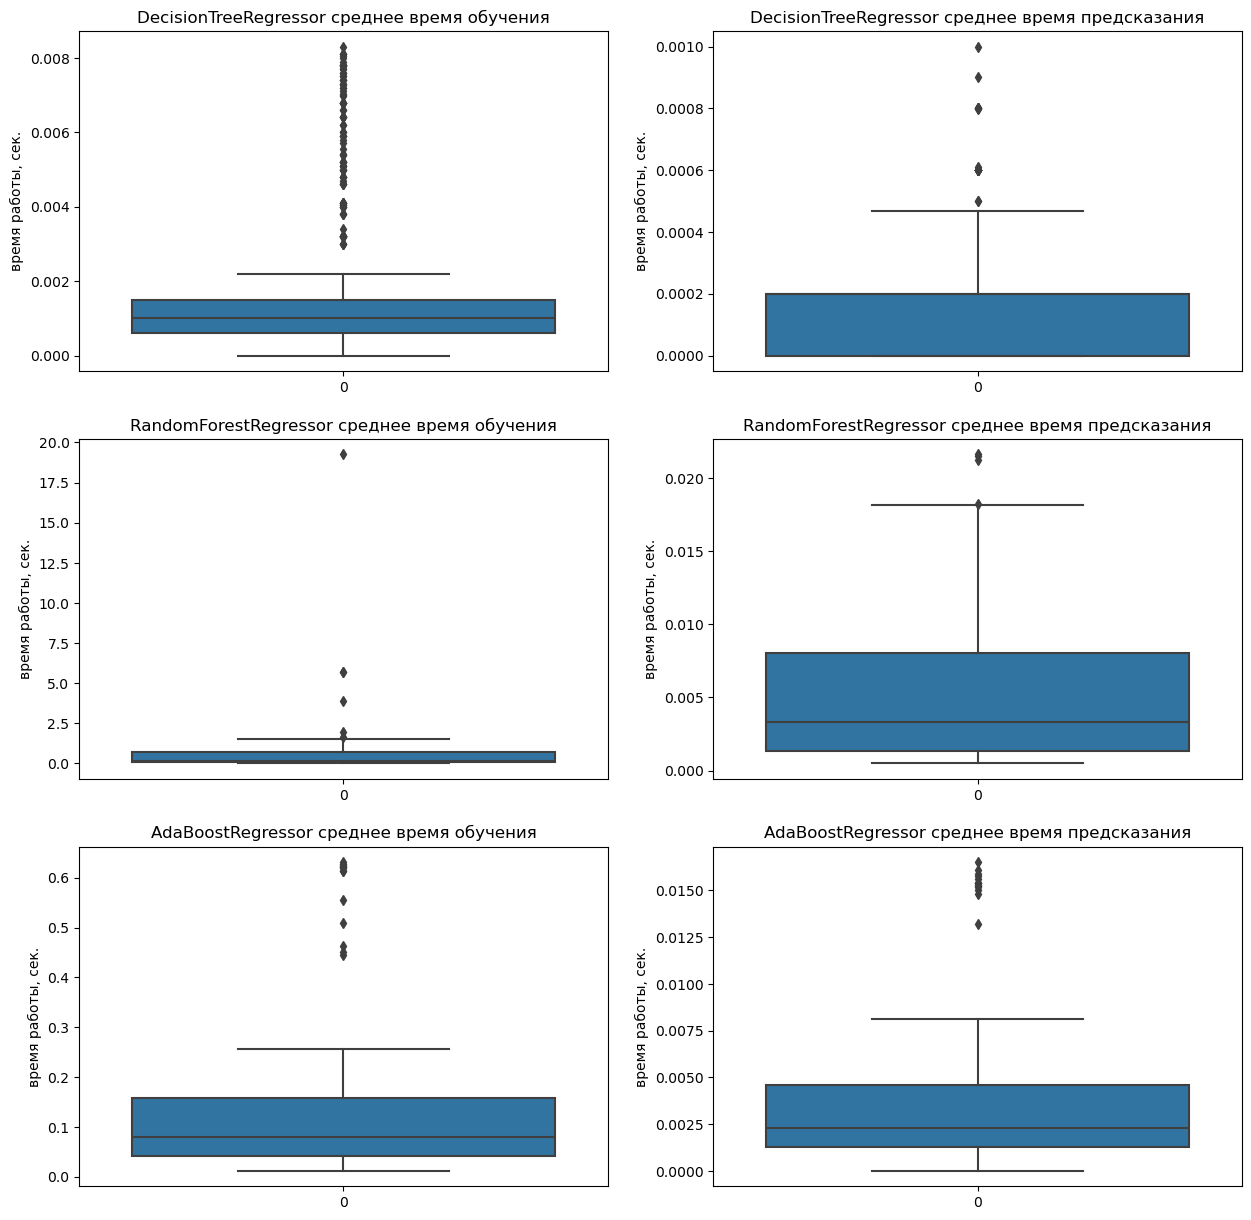

In [87]:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
i = 0

for GSCV in {grid_search_dt, grid_search_ab, grid_search_rf}:
    mft = GSCV.cv_results_["mean_fit_time"]
    mst = GSCV.cv_results_["mean_score_time"]

    sns.boxplot(data=mft, ax=ax[i, 0])
    ax[i, 0].set_title(str(GSCV.best_estimator_.__class__.__name__)+" среднее время обучения")
    ax[i, 0].set_ylabel("время работы, сек.")

    sns.boxplot(data=mst, ax=ax[i, 1])
    ax[i, 1].set_title(str(GSCV.best_estimator_.__class__.__name__)+" среднее время предсказания")
    ax[i, 1].set_ylabel("время работы, сек.")

    i+=1

Наблюдаем следующую картину: на графиках четко выделены аномальные значения. `seaborn.boxplot` выделяет их черными ромбами - значения, для которых выполняется: 
$$value \in (-\infty; Q_1-1.5\times IQR)\ \cup \ (Q_3+1.5\times IQR; + \infty) $$

Рассмотрим подробно какие гиперпараметры повлияли на появление таких данных:

In [88]:
for GSCV in {grid_search_dt, grid_search_ab, grid_search_rf}:
    mft = GSCV.cv_results_["mean_fit_time"]
    # mst = GSCV.cv_results_["mean_score_time"]

    q1 = np.quantile(mft, 0.25)
    q3 = np.quantile(mft, 0.75)
    iqr = q3-q1
    lower_b = q1-(1.5*iqr)
    upper_b = q3+(1.5*iqr)
    values = list(mft)

    # Считаем выбросы
    outlier_arr = []
    print("Параметры моделей "+str(GSCV.best_estimator_.__class__.__name__)+", для которых время предсказания позиционируется как аномальное значение:")

    for elem in values:
        if elem > upper_b:
            outlier_arr.append(values.index(elem))

    for idx in outlier_arr:
        print(GSCV.cv_results_['params'][idx])

    print("\n")
    

Параметры моделей DecisionTreeRegressor, для которых время предсказания позиционируется как аномальное значение:
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 2, 'max_features': 'sqrt'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 2, 'max_features': 'log2'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 'sqrt'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 'log2'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 4, 'max_features': 'sqrt'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 4, 'max_features': 'log2'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'sqrt'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 5, 'max_features': 'log2'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 6, 'max_features': 'sqrt'}
{'ccp_alpha': 0.0, 'criterion': 'absolute_error', 'max_depth': 6, 'max_featur

In [96]:
# В случайном лесе есть один набор гиперпараметров, который занимает почти 20 секунд на обучение. Посмотрим на его параметры:
mft = list(grid_search_rf.cv_results_["mean_fit_time"])

for elem in mft:
        if elem > 17.5:
            print(f'Время обучения составило {elem:.3f} секунд\n')
            anomaly_idx = mft.index(elem)
print("Гиперпараметры модели:")
print(grid_search_rf.cv_results_['params'][anomaly_idx])

Время обучения составило 19.256 секунд

Гиперпараметры модели:
{'criterion': 'absolute_error', 'max_features': None, 'n_estimators': 500}


**Решающее дерево**: если ставить критерий `absolute_error`, то модель дольше обучается. Возможное объяснение (этот момент также описан в __[документации SKLearn](https://scikit-learn.org/stable/modules/tree.html#regression-criteria)__ и __[ветке issues библиотеки 2017 года](https://github.com/scikit-learn/scikit-learn/issues/9553#issuecomment-324484928)__): критерий MAE реализован за $O(n^2)$. В случайном лесе та же реализация;

**AdaBoost**: естественно ожидать, что при увеличении количества регрессеров в ансамбле, бустинг будет дольше обучаться. Также (здесь не показано) время предсказания, соответственно, увеличится. Предыдущее значение `n_estimators`$=100 < 500$, естественно ожидать увеличение времени в $\approx 5$ раз;

**Случайный лес**: оба вышеописанных фактора наложились на эту модель: реализация MAE критерия за $O(n^2)$ и высокое количество регрессеров в ансамбле. Самое долгое время обучения (19.256 секунд) как раз заняла модель со следующими гиперпараметрами:
- 'criterion': 'absolute_error'; 
- 'max_features': None (т.е. `max_features=n_features`);
- 'n_estimators': 500

**Как ускорить?**: использовать эффективную и подходящую реализацию вспомогательных функций. Также с увеличением количества регрессеров в ансамбле, в какой-то момент качество модели выходит на плато - поэтому не стоит использовать много естиматоров.

## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

Достаточно использовать `svd_solver='full'`, т.к. размерность матрицы не столь огромна, чтобы использовать `svd_solver='randomized'`, а `svd_solver='arpack'` не совсем подходит для нашей задачи оценки количества компонент: согласно __[документации SKLearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)__:

$$ n_{components} \in (0, min(dim(X)))$$

А нам надо объяснить отклонение при всех признаках

In [48]:
pca_full = PCA(n_components=X_train.shape[1], svd_solver='full', random_state=RANDOM_STATE)
pca_full.fit(X_train_scaled)

PCA(n_components=11, random_state=43, svd_solver='full')

Text(0, 0.5, 'Explained Variance (объясненное отклонение), ratio')

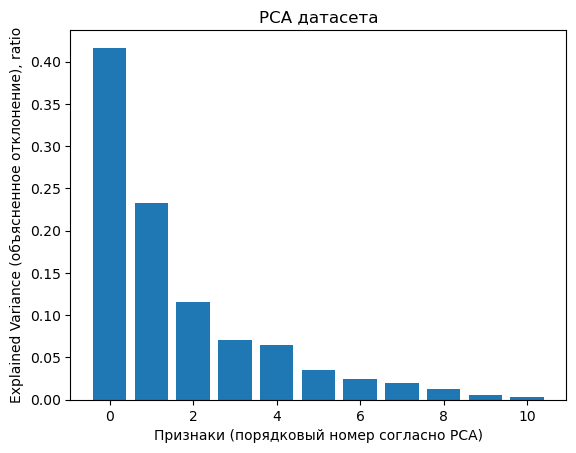

In [49]:
fig, ax = plt.subplots(1, 1)
res = pca_full.explained_variance_ratio_
ax.bar(list(range(0,len(res))), res)
ax.set_title("PCA датасета")
ax.set_xlabel("Признаки (порядковый номер согласно PCA)")
ax.set_ylabel("Explained Variance (объясненное отклонение), ratio")

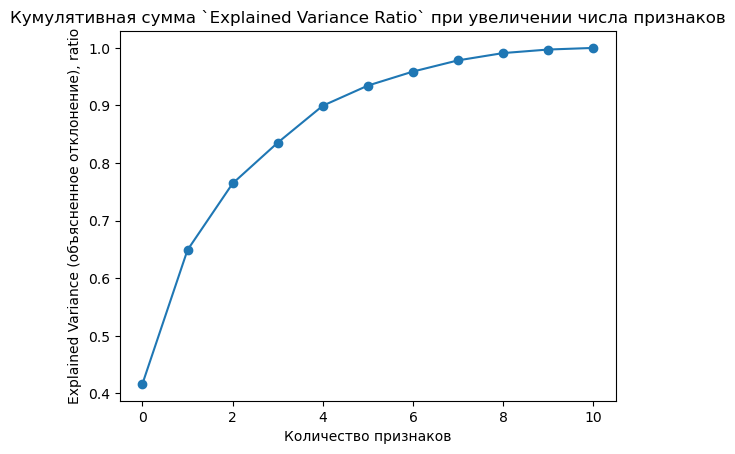

In [50]:
cumulative_variance_ratio = np.cumsum(res)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Количество признаков')
plt.ylabel('Explained Variance (объясненное отклонение), ratio')
plt.title('Кумулятивная сумма `Explained Variance Ratio` при увеличении числа признаков')
plt.show()

Видно, что наибольший вклад в предсказание моделей можно добиться 9 признаками. Можно взять и 6, но вклад фичей с 6 по 8 существенен, когда как последние признаки не имеют эффекта на предсказание.

In [51]:
pca = PCA(n_components=9, svd_solver='full', random_state=RANDOM_STATE) # Подобрал
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Обучение моделей на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Какой алгоритм справился лучше? Какой быстрее? Почему?

In [52]:
dt_better_pca = DecisionTreeRegressor(random_state=RANDOM_STATE)
ab_better_pca = AdaBoostRegressor(random_state=RANDOM_STATE)
rf_better_pca = RandomForestRegressor(random_state=RANDOM_STATE)
res_withGridSearch_withPCA = {}

## **Решающее дерево**

Снова внедряем в поиск по сетке прунинг дерева - поиск оптимального `ccp_alpha`:

In [53]:
param_grid = {'max_features': ['sqrt', 'log2'],
              'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8, 9],
              'criterion' :['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
              'ccp_alpha' : [0.000, 0.002, 0.004, 0.006, 0.008, 0.010],
             }

grid_search_dt_pca = GridSearchCV(estimator=dt_better_pca, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_dt_pca.fit(X_train_pca, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=43),
             param_grid={'ccp_alpha': [0.0, 0.002, 0.004, 0.006, 0.008, 0.01],
                         'criterion': ['poisson', 'squared_error',
                                       'absolute_error', 'friedman_mse'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2']},
             scoring='r2', verbose=1)

In [54]:
dt_better_pca = grid_search_dt_pca.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(dt_better_pca.get_params())

res_withGridSearch_withPCA['pruned'] = grid_search_dt_pca.best_score_

best estimator hyperparameters:
	 ccp_alpha = 0.006
	 criterion = squared_error
	 max_depth = 7
	 max_features = sqrt


In [55]:
print("Decision Tree with general hyperparameters w//o PCA: r2 score =", res_noGridSearch_noPCA['pruned'])
print("Decision Tree with oprimal hyperparameters w//o PCA: r2 score =", res_withGridSearch_noPCA['pruned'])
print("Decision Tree with oprimal hyperparameters with PCA: r2 score =", res_withGridSearch_withPCA['pruned'])

Decision Tree with general hyperparameters w//o PCA: r2 score = 0.293
Decision Tree with oprimal hyperparameters w//o PCA: r2 score = 0.30723240430109383
Decision Tree with oprimal hyperparameters with PCA: r2 score = 0.23102616213990562


Здесь и далее мы увидим незначительные увеличения точности модели при подборе оптимальных гиперпараметров. Это можно обосновать тем, что большинство гиперпараметров выставляются автоматически, согласно документации SKLearn.

## **AdaBoost**

In [56]:
param_grid = {'loss': ['linear', 'square', 'exponential'],
              'n_estimators': [10, 50, 100, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
             }

grid_search_ab_pca = GridSearchCV(estimator=ab_better_pca, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_ab_pca.fit(X_train_pca, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=True),
             estimator=AdaBoostRegressor(random_state=43),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='r2', verbose=1)

In [57]:
ab_better_pca = grid_search_ab_pca.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(ab_better_pca.get_params())

res_withGridSearch_withPCA[str(ab_better_pca.__class__.__name__)] = grid_search_ab_pca.best_score_

best estimator hyperparameters:
	 learning_rate = 0.1
	 loss = exponential
	 n_estimators = 100


In [58]:
name = str(ab_better_pca.__class__.__name__)
print("AdaBoost Regressor with general hyperparameters w//o PCA: r2 score =", res_noGridSearch_noPCA[name])
print("AdaBoost Regressor with oprimal hyperparameters w//o PCA: r2 score =", res_withGridSearch_noPCA[name])
print("AdaBoost Regressor with oprimal hyperparameters with PCA: r2 score =", res_withGridSearch_withPCA[name])

AdaBoost Regressor with general hyperparameters w//o PCA: r2 score = 0.3412
AdaBoost Regressor with oprimal hyperparameters w//o PCA: r2 score = 0.36396379977461985
AdaBoost Regressor with oprimal hyperparameters with PCA: r2 score = 0.3286632539137037


## **Случайный лес**

In [97]:
param_grid = {'max_features': ['sqrt', 'log2', None],
              'n_estimators': [10, 50, 100, 500],
              'criterion' :['poisson', 'squared_error', 'absolute_error', 'friedman_mse'],
             }

grid_search_rf_pca = GridSearchCV(estimator=rf_better_pca, param_grid=param_grid, cv=custom_cv, verbose=1, scoring='r2')
grid_search_rf_pca.fit(X_train_pca, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=43, shuffle=True),
             estimator=RandomForestRegressor(criterion='poisson',
                                             max_features='sqrt',
                                             n_estimators=500,
                                             random_state=43),
             param_grid={'criterion': ['poisson', 'squared_error',
                                       'absolute_error', 'friedman_mse'],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 50, 100, 500]},
             scoring='r2', verbose=1)

In [98]:
rf_better_pca = grid_search_rf_pca.best_estimator_ # сохраним лучшую модель для тестирования в будущем
print("best estimator hyperparameters:")
print_params(rf_better_pca.get_params())

res_withGridSearch_withPCA[str(rf_better_pca.__class__.__name__)] = grid_search_rf_pca.best_score_

best estimator hyperparameters:
	 ccp_alpha = 0.0
	 criterion = poisson
	 max_depth = None
	 max_features = sqrt
	 n_estimators = 500


In [99]:
name = str(rf_better_pca.__class__.__name__)
print("Random Forest Regressor with general hyperparameters w//o PCA: r2 score =", res_noGridSearch_noPCA[name])
print("Random Forest Regressor with oprimal hyperparameters w//o PCA: r2 score =", res_withGridSearch_noPCA[name])
print("Random Forest Regressor with oprimal hyperparameters with PCA: r2 score =", res_withGridSearch_withPCA[name])

Random Forest Regressor with general hyperparameters w//o PCA: r2 score = 0.3748
Random Forest Regressor with oprimal hyperparameters w//o PCA: r2 score = 0.39086615220919274
Random Forest Regressor with oprimal hyperparameters with PCA: r2 score = 0.366306616980537


## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о моделях регрессии с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

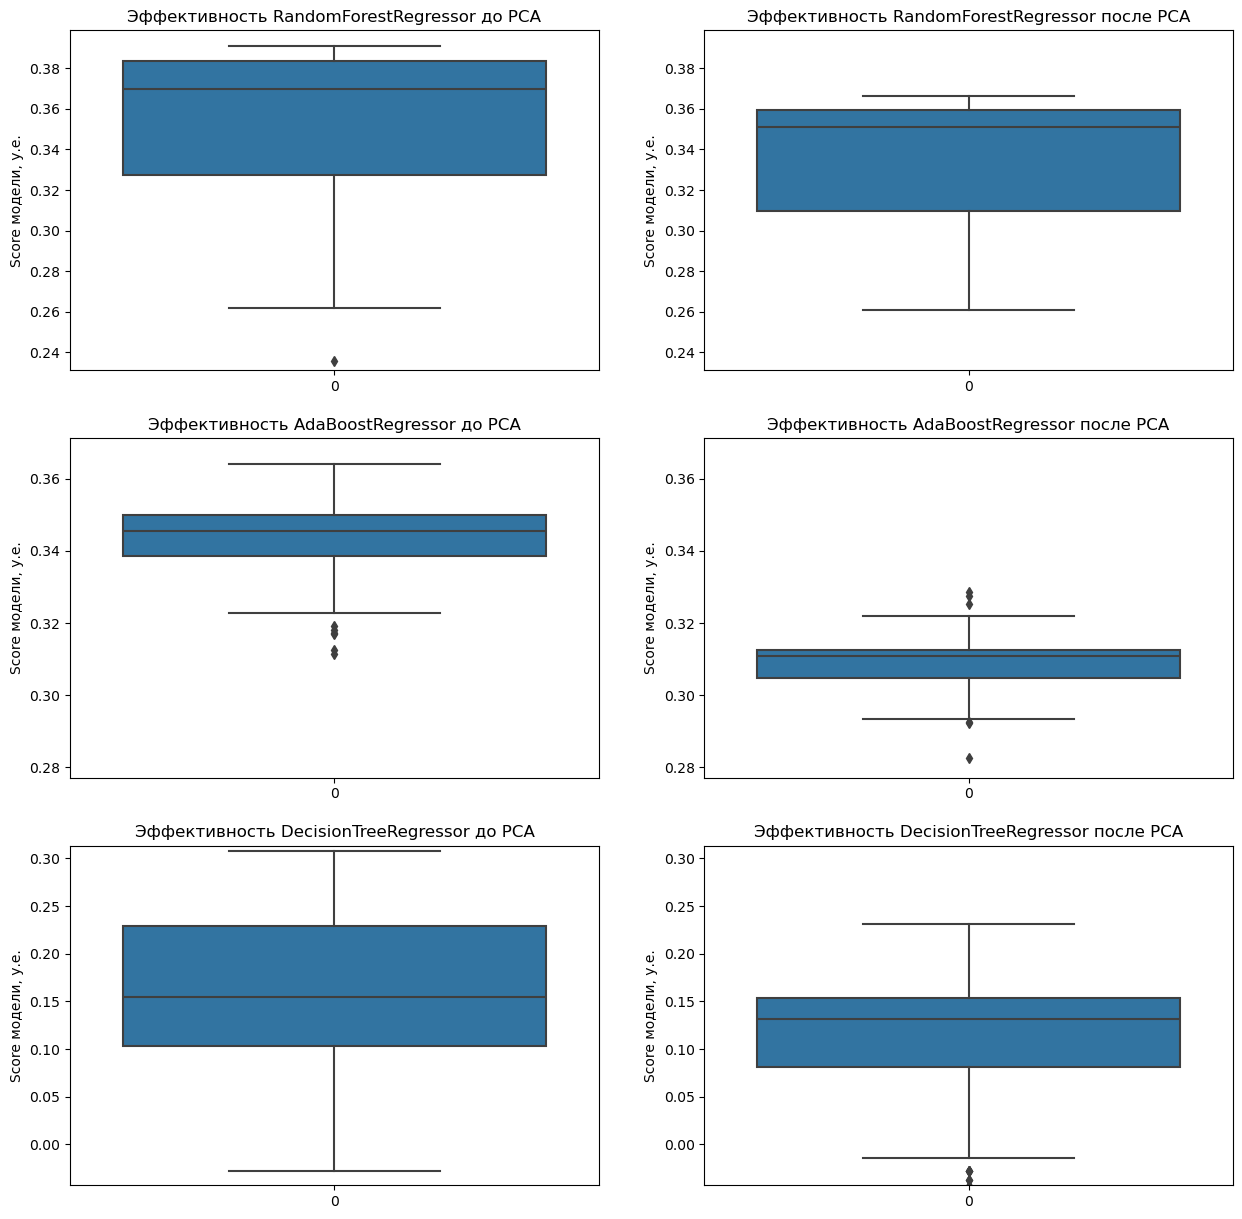

In [100]:
fig, ax = plt.subplots(3, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
i = 0

pairs = {(grid_search_dt, grid_search_dt_pca), (grid_search_ab, grid_search_ab_pca), (grid_search_rf, grid_search_rf_pca)}

for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_score"]
    mts_pca = GSCV[1].cv_results_["mean_test_score"]

    # Для читаемости
    min = np.min(mts_cmn) if (np.min(mts_pca) > np.min(mts_cmn)) else np.min(mts_pca)
    max = np.max(mts_cmn) if (np.max(mts_pca) < np.max(mts_cmn)) else np.max(mts_pca)
    mul = 1.02
    min /= mul
    max *= mul

    sns.boxplot(data=mts_cmn, ax=ax[i, 0])
    ax[i, 0].set_title("Эффективность "+str(GSCV[0].best_estimator_.__class__.__name__)+" до PCA")
    ax[i, 0].set_ylabel("Score модели, у.е.")
    ax[i, 0].set(ylim=(min, max))

    sns.boxplot(data=mts_pca, ax=ax[i, 1])
    ax[i, 1].set_title("Эффективность "+str(GSCV[1].best_estimator_.__class__.__name__)+" после PCA")
    ax[i, 1].set_ylabel("Score модели, у.е.")
    ax[i, 1].set(ylim=(min, max))

    i+=1

Посмотрим сначала на параметры моделей со следующим условием:
$$ score \in (Q3;\ Q3+1.5\times IQR) $$

In [109]:
for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_score"]
    mts_pca = GSCV[1].cv_results_["mean_test_score"]

    i = 0
    models = [[], []]
    print("Параметры моделей "+str(GSCV[-1].best_estimator_.__class__.__name__)+", для которых качество предсказания (mean test score) лучше верхнего квартиля (и не аномальное):")

    for scores in (mts_cmn, mts_pca):
        q1 = np.quantile(scores, 0.25)
        q3 = np.quantile(scores, 0.75)
        iqr = q3-q1
        lower_b = q1-(1.5*iqr)
        upper_b = q3+(1.5*iqr)
        values = list(scores)

        for elem in values:
            if elem < upper_b and elem > q3:
                models[i].append(values.index(elem))
        
        if i==0:
            print("\tПараметры моделей до PCA:")
        else:
            print("\tПараметры моделей после PCA:")

        for idx in models[i]:
            print(f"\t\t {GSCV[i].cv_results_['params'][idx]}, score={GSCV[i].cv_results_['mean_test_score'][idx]:.3f}")

        ###
        print('\n')
        i+=1

Параметры моделей RandomForestRegressor, для которых качество предсказания (mean test score) лучше верхнего квартиля (и не аномальное):
	Параметры моделей до PCA:
		 {'criterion': 'poisson', 'max_features': 'sqrt', 'n_estimators': 100}, score=0.391
		 {'criterion': 'poisson', 'max_features': 'sqrt', 'n_estimators': 500}, score=0.388
		 {'criterion': 'poisson', 'max_features': 'sqrt', 'n_estimators': 100}, score=0.391
		 {'criterion': 'poisson', 'max_features': 'sqrt', 'n_estimators': 500}, score=0.388
		 {'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 100}, score=0.388
		 {'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 500}, score=0.390
		 {'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 100}, score=0.388
		 {'criterion': 'squared_error', 'max_features': 'sqrt', 'n_estimators': 500}, score=0.390
		 {'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 100}, score=0.388
		 {'criterion': 'friedman_mse', '

После PCA трансформации скор ухудшился, но относительно обоих медиан моделей не так сильно (кроме модели `AdaBoost`). PCA не панацея - согласно матрице корреляций мы наблюдали 4 пары коррелирующих значений и по идее PCA должен был помочь в этом. Благодаря графику `explained variance` была уменьшена размерность, но все равно трансформацию не стоило использовать, т.к. размерность уменьшилась на $2$, когда PCA используется для датасетов с высокой размерностью.

**AdaBoost:** сюда попали более "шустрые" модели, с высоким `learning_rate`. Этот параметр увеличивает вес, с которым каждый регрессор в бустинге влияет на результирующее предсказание. Важно помнить, что существует т.н. "tradeoff" между параметрами `learning_rate` и `n_estimators`. Поэтому стоит ожидать у оптимального параметра значения, близкие к золотой середине.

**Random Forest:** для случайного леса сильно влияет на точность предсказания количество `n_estimators`, но стоит обратить внимание, что среди `max_features` появляется только `sqrt` и `auto`. Согласно эмпирическим данным, для задачи регрессии подходит `auto`, который __[превращает](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)__ Случайный лес в Беггинг над деревьями, т.к. в этом случае `max_features=n_features`. Но для леса хорошей отправной точкой все еще является `sqrt`, который выделяет лес от беггинга над деревьями.

**Decision Tree:** Его точность значительно упала после PCA. К тому же среди моделей нет критерия MAE - его использовать больше не будем.

____

Теперь посмотрим на аномально высокие скоры, т.е. для которых выполняется:
$$ score > Q3+1.5\times IQR $$

Если таких данных не будет, то напишем параметры лучшей модели.

In [121]:
for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_score"]
    mts_pca = GSCV[1].cv_results_["mean_test_score"]

    i = 0
    models = [[], []]
    print("Параметры моделей "+str(GSCV[-1].best_estimator_.__class__.__name__)+", для которых качество предсказания (mean test score) аномально-высокое:")

    for scores in (mts_cmn, mts_pca):
        q1 = np.quantile(scores, 0.25)
        q3 = np.quantile(scores, 0.75)
        iqr = q3-q1
        lower_b = q1-(1.5*iqr)
        upper_b = q3+(1.5*iqr)
        values = list(scores)

        for elem in values:
            if elem >= upper_b:
                models[i].append(values.index(elem))

        if i==0:
            if models[i] == []:
                print(f"\tПараметры лучшей модели до PCA: \n\t\t{GSCV[i].best_estimator_.get_params(False)}")
            else:
                print("\tПараметры моделей до PCA:")
        else:
            if models[i] == []:
                print(f"\tПараметры лучшей модели после PCA: \n\t\t{GSCV[i].best_estimator_.get_params(False)}")
            else:
                print("\tПараметры моделей после PCA:")

        for idx in models[i]:
            print(f"\t\t {GSCV[i].cv_results_['params'][idx]}, score={GSCV[i].cv_results_['mean_test_score'][idx]:.3f}")

        ###
        print('\n')
        i+=1

Параметры моделей RandomForestRegressor, для которых качество предсказания (mean test score) аномально-высокое:
	Параметры лучшей модели до PCA: 
		{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 43, 'verbose': 0, 'warm_start': False}


	Параметры лучшей модели после PCA: 
		{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'poisson', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 43, 'verbose': 0, 'warm_start': False}


Параметры моделей AdaBoostRegressor, для которых качество предска

Аномальные значения только у `AdaBoostRegressor`, но даже они меньше нижнего квартиля точности модели до PCA. Лучший скор (как до PCA, так и после) оказался у модели, в которой есть баланс между `learning_rate` и `n_estimators`, как ожидалось.

___

Теперь посмотрим на аномально низкие скоры, т.е. для которых выполняется:
$$ score < Q1-1.5\times IQR $$

Если таких данных не будет, то напишем параметры худшей модели.

In [122]:
for GSCV in pairs:
    mts_cmn = GSCV[0].cv_results_["mean_test_score"]
    mts_pca = GSCV[1].cv_results_["mean_test_score"]

    i = 0
    models = [[], []]
    print("Параметры моделей "+str(GSCV[-1].best_estimator_.__class__.__name__)+", для которых качество предсказания (mean test score) аномально-низкое:")

    for scores in (mts_cmn, mts_pca):
        q0 = np.quantile(scores, 0.0)
        q1 = np.quantile(scores, 0.25)
        q3 = np.quantile(scores, 0.75)
        iqr = q3-q1
        lower_b = q1-(1.5*iqr)
        upper_b = q3+(1.5*iqr)
        values = list(scores)

        lowest_idx = -1
        for elem in values:
            if elem == q0:
                lowest_idx = values.index(elem)
            if elem <= lower_b:
                models[i].append(values.index(elem))

        if i==0:
            if models[i] == []:
                print(f"\tПараметры худшей модели до PCA: \n\t\t{GSCV[i].cv_results_['params'][lowest_idx]}, score={GSCV[i].cv_results_['mean_test_score'][lowest_idx]:.3f}")
            else:
                print("\tПараметры моделей до PCA:")
        else:
            if models[i] == []:
                print(f"\tПараметры худшей модели после PCA: \n\t\t{GSCV[i].cv_results_['params'][lowest_idx]}, score={GSCV[i].cv_results_['mean_test_score'][lowest_idx]:.3f}")
            else:
                print("\tПараметры моделей после PCA:")

        for idx in models[i]:
            print(f"\t\t {GSCV[i].cv_results_['params'][idx]}, score={GSCV[i].cv_results_['mean_test_score'][idx]:.3f}")

        ###
        print('\n')
        i+=1

Параметры моделей RandomForestRegressor, для которых качество предсказания (mean test score) аномально-низкое:
	Параметры моделей до PCA:
		 {'criterion': 'absolute_error', 'max_features': None, 'n_estimators': 10}, score=0.236


	Параметры худшей модели после PCA: 
		{'criterion': 'absolute_error', 'max_features': 'sqrt', 'n_estimators': 10}, score=0.261


Параметры моделей AdaBoostRegressor, для которых качество предсказания (mean test score) аномально-низкое:
	Параметры моделей до PCA:
		 {'learning_rate': 0.0001, 'loss': 'linear', 'n_estimators': 10}, score=0.317
		 {'learning_rate': 0.0001, 'loss': 'square', 'n_estimators': 10}, score=0.319
		 {'learning_rate': 0.0001, 'loss': 'exponential', 'n_estimators': 10}, score=0.318
		 {'learning_rate': 0.001, 'loss': 'linear', 'n_estimators': 10}, score=0.313
		 {'learning_rate': 0.001, 'loss': 'square', 'n_estimators': 10}, score=0.317
		 {'learning_rate': 0.001, 'loss': 'exponential', 'n_estimators': 10}, score=0.311


	Параметры моделе

**AdaBoost:** сюда попали модели без баланса между `learning_rate` и `n_estimators`: слишком малое значение обоих параметров приводит к слабой модели (без раскрытия потенциала идеи бустинга), тоже самое можно сказать про модель с максимальными значениями обоих параметров;

**Random Forest (только до PCA):** малое количество `n_estimators` в случайном лесу приводит к тем же результатам, что и в `AdaBoostRegressor`. К тому же тут играет роль MAE критерий, который, как мы поняли ранее, не эффективный;

**Decision Tree (только после PCA):** решающее дерево без прунинга - очень слабая модель. Поэтому мы видим отрицательные результаты, которые говорят о том, что эти деревья менее эффективны, чем модель, которая будет возвращать среднее значение целевой переменной.

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 30%). Не забудьте про все необходимые преобразования.

In [128]:
# (гиперпараметры по умолчанию, оптимальные гиперпараметры, оптимальные гиперпараметры после PCA)
pairs = {(dt_basic_pruned, grid_search_dt.best_estimator_, grid_search_dt_pca.best_estimator_), 
         (ab_basic.fit(X_train_scaled, y_train), grid_search_ab.best_estimator_, grid_search_ab_pca.best_estimator_), 
         (rf_basic.fit(X_train_scaled, y_train), grid_search_rf.best_estimator_, grid_search_rf_pca.best_estimator_)}

for estimators in pairs:
    print(f"Итоги для {estimators[0].__class__.__name__}")
    y_pred_basic = estimators[0].predict(X_test_scaled)
    r2_basic = r2_score(y_test, y_pred_basic)
    print(f"\tКоэффициент детерминации до PCA с гиперпараметрами по умолчанию: {r2_basic:.3f}")

    y_pred_better = estimators[1].predict(X_test_scaled)
    r2_better = r2_score(y_test, y_pred_better)
    print(f"\tКоэффициент детерминации до PCA с оптимальными гиперпараметрами: {r2_better:.3f}")

    y_pred_better_pca = estimators[2].predict(X_test_pca)
    r2_pca = r2_score(y_test, y_pred_better_pca)
    print(f"\tКоэффициент детерминации после PCA с оптимальными гиперпараметрами: {r2_pca:.3f}")

    print('\n')
    

Итоги для DecisionTreeRegressor
	Коэффициент детерминации до PCA с гиперпараметрами по умолчанию: 0.255
	Коэффициент детерминации до PCA с оптимальными гиперпараметрами: 0.271
	Коэффициент детерминации после PCA с оптимальными гиперпараметрами: 0.170


Итоги для RandomForestRegressor
	Коэффициент детерминации до PCA с гиперпараметрами по умолчанию: 0.356
	Коэффициент детерминации до PCA с оптимальными гиперпараметрами: 0.380
	Коэффициент детерминации после PCA с оптимальными гиперпараметрами: 0.352


Итоги для AdaBoostRegressor
	Коэффициент детерминации до PCA с гиперпараметрами по умолчанию: 0.351
	Коэффициент детерминации до PCA с оптимальными гиперпараметрами: 0.362
	Коэффициент детерминации после PCA с оптимальными гиперпараметрами: 0.284




# Вывод

Вероятно датасет был не совсем корректно предобработан, но коэффициент детерминации крайне низкий. К тому же PCA ухудшил скор моделей (совсем грустно на `AdaBoostRegressor`). Попробуем убрать признак `fixed_acidity` и не трансформировать датасет PCA:

In [129]:
dataset_pd.drop(columns=['fixed acidity'], inplace=True)

dataset_np = dataset_pd.to_numpy()
data = dataset_np[:, :-1].astype(float)
target = dataset_np[:, -1]

print(data.shape, target.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.30, random_state=777)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

from sklearn.preprocessing import RobustScaler

scaler = RobustScaler().fit(X_train)
#scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

(1344, 10) (1344,)
(940, 10) (940,) (404, 10) (404,)


In [135]:
print("Robust Scaler:")
model_test_ab = AdaBoostRegressor(random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
print(f"AdaBoost: r2 score: {r2_score(y_test, model_test_ab.predict(X_test_scaled)):.3f}")

model_test_dt = DecisionTreeRegressor(ccp_alpha=0.008, random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
print(f"Pruned DT: r2 score: {r2_score(y_test, model_test_dt.predict(X_test_scaled)):.3f}")

model_test_rf = RandomForestRegressor(random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
print(f"RandomForest: r2 score: {r2_score(y_test, model_test_rf.predict(X_test_scaled)):.3f}")

#####################

print("\nStandartScaler:")
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model_test_ab = AdaBoostRegressor(random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
print(f"AdaBoost: r2 score: {r2_score(y_test, model_test_ab.predict(X_test_scaled)):.3f}")

model_test_dt = DecisionTreeRegressor(ccp_alpha=0.008, random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
print(f"Pruned DT: r2 score: {r2_score(y_test, model_test_dt.predict(X_test_scaled)):.3f}")

model_test_rf = RandomForestRegressor(random_state=RANDOM_STATE).fit(X_train_scaled, y_train)
print(f"RandomForest: r2 score: {r2_score(y_test, model_test_rf.predict(X_test_scaled)):.3f}")

Robust Scaler:
AdaBoost: r2 score: 0.361
Pruned DT: r2 score: 0.255


RandomForest: r2 score: 0.363

StandartScaler:
AdaBoost: r2 score: 0.361
Pruned DT: r2 score: 0.255
RandomForest: r2 score: 0.363


Точность моделей получилась не хуже, чем на датасете с признаком `fixed_acidity`. Это позволяет сделать вывод, что вероятнее всего стоит продолжить анализ датасета и искать альтернативные пути к лучшему скору. PCA не всегда дает выигрыш в точности моделей.